In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Loaded the dataset and inspected the first few rows.

In [3]:
df_copy = df.copy()
df_copy = pd.get_dummies(df_copy, columns=['sex', 'smoker', 'region'], drop_first=True)
df_copy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Encoded categorical variables into numerical format using one-hot encoding.

In [4]:
df_copy.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: >

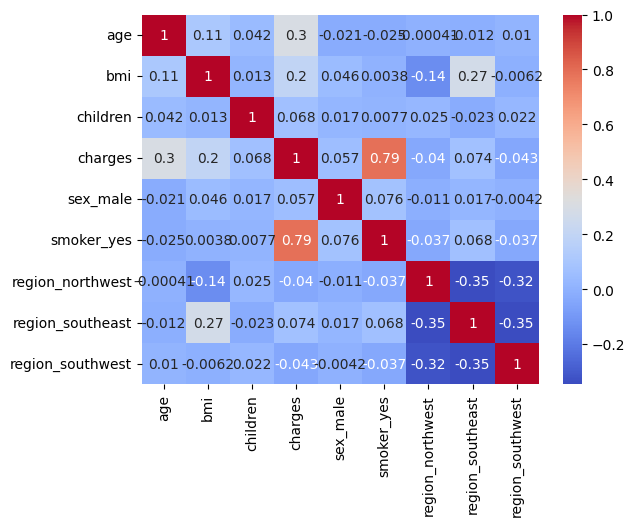

In [5]:
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')

In [6]:
#In the other ipynb file we see bmi some outliers exist. We can handle them if necessary.
Q1 = df_copy['bmi'].quantile(0.25)
Q3 = df_copy['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
len(df_copy[(df_copy['bmi'] < lower_bound) | (df_copy['bmi'] > upper_bound)])
#so there is only 9 outliers in bmi column. We can remove them.
df_copy = df_copy[(df_copy['bmi'] >= lower_bound) & (df_copy['bmi'] <= upper_bound)]
df_copy.shape

(1329, 9)

Removed outliers from the 'bmi' column to improve data quality.

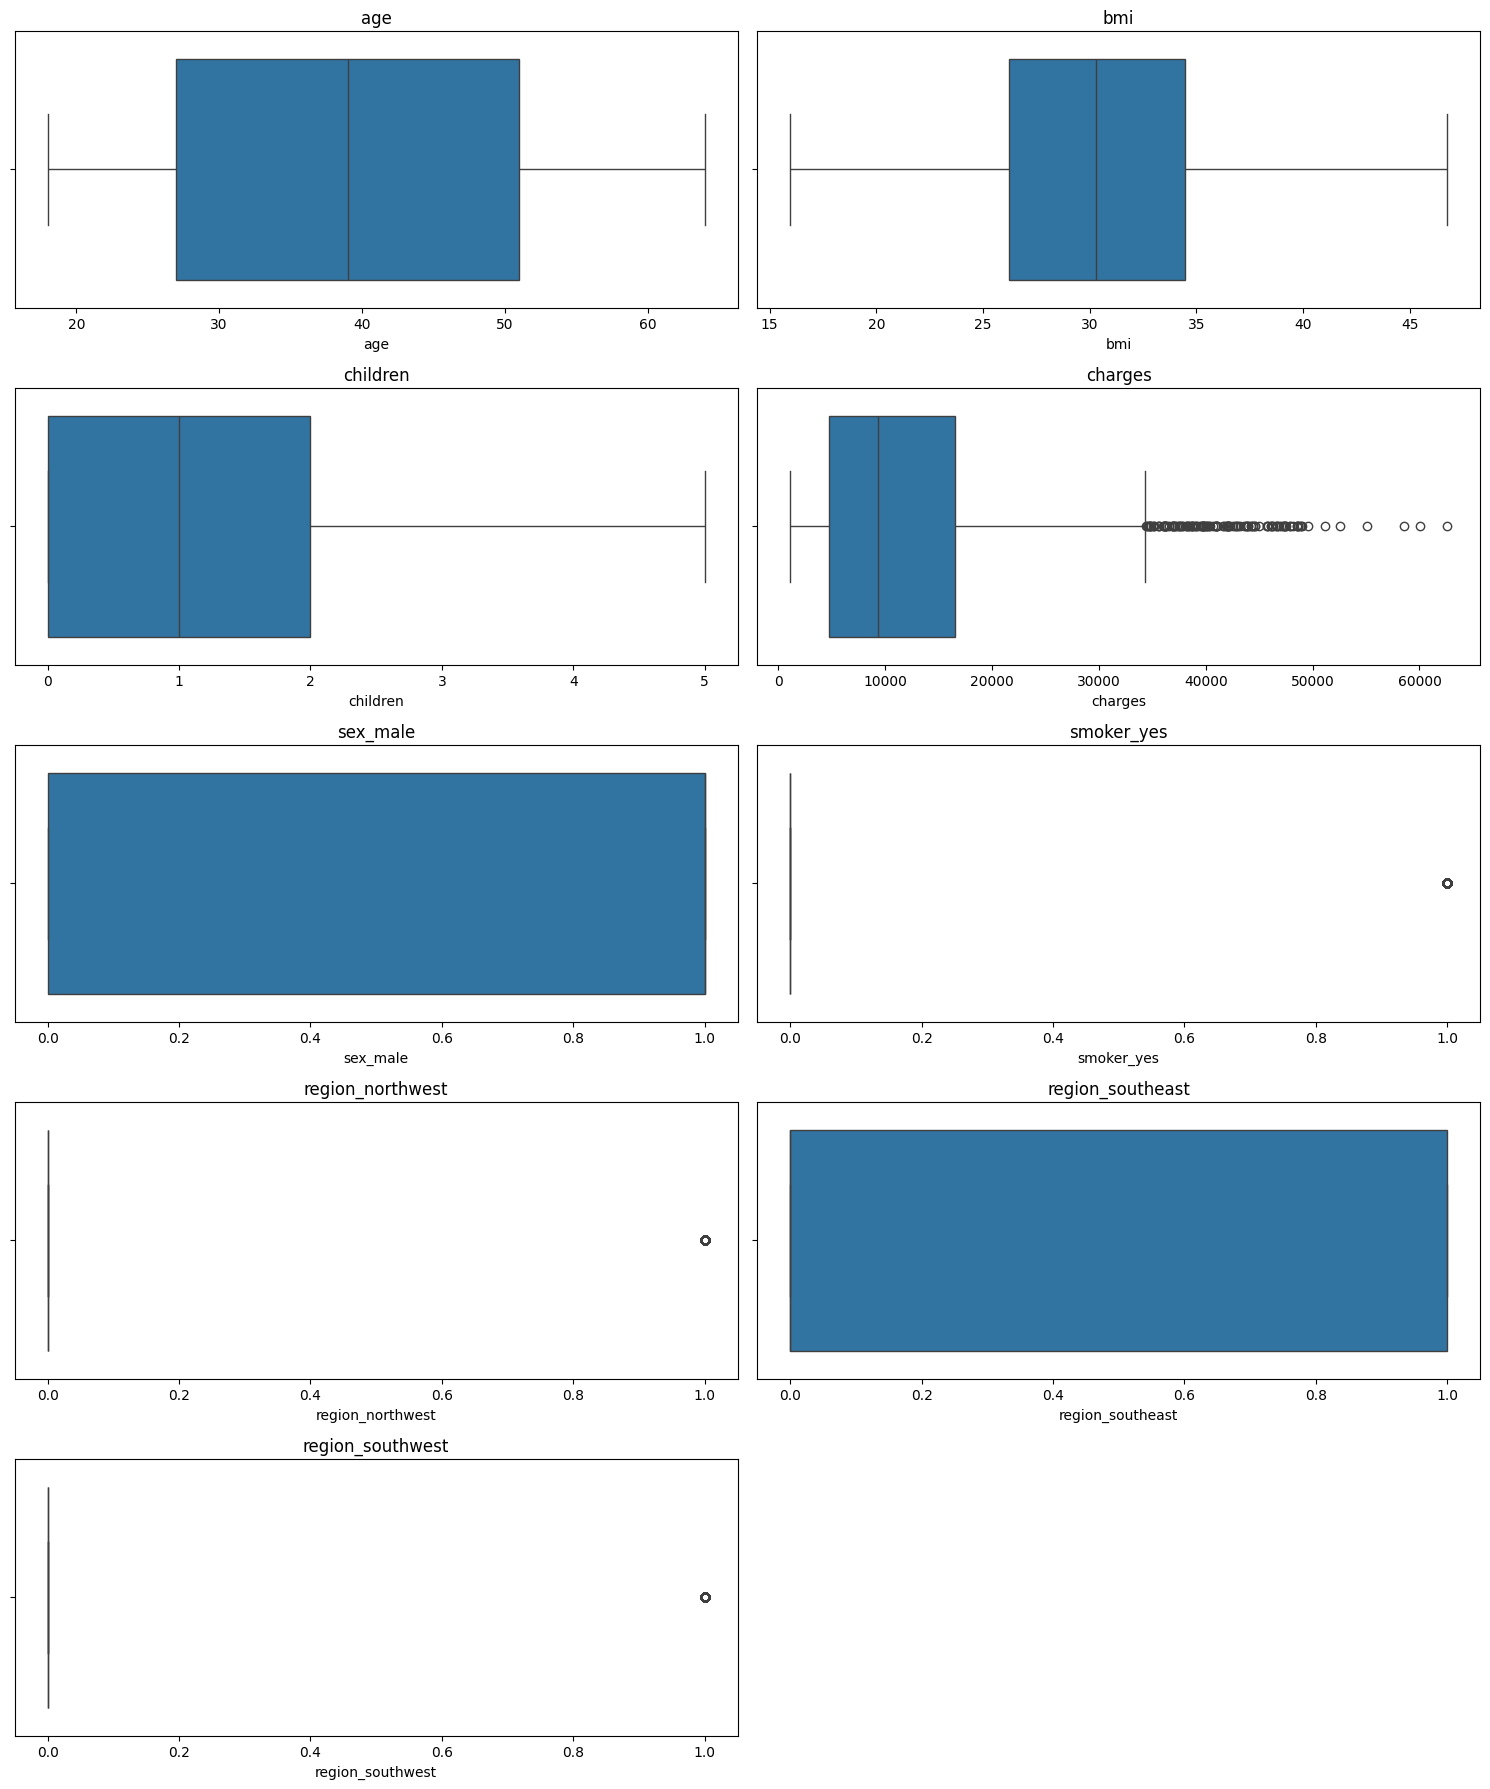

In [7]:
plt.figure(figsize=(15, len(df_copy.columns) * 2)) 
for i, col in enumerate(df_copy.columns, 1):
    plt.subplot(len(df_copy.columns) // 2 + 1, 2, i) 
    sns.boxplot(x=col, data=df_copy)
    plt.title(col)

plt.tight_layout()
plt.show()

Checked for outliers across all features using boxplots.

In [8]:
from sklearn.model_selection import train_test_split
X = df_copy.drop('charges', axis=1)
y = df_copy['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Split the data into training and testing sets.

In [11]:
#Now we can delete columns that is more correlated each other ,in our train and test data
#we do this to prevent multicollinearity
def correlation_for_dropping(data, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr # use these func when you want to drop highly correlated columns from your dataset to reduce multicollinearity and redundancy

Defined a function to detect high correlation between features to avoid multicollinearity.

In [13]:
print(correlation_for_dropping(X_train, 0.85))

set()


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaled the features to ensure they have zero mean and unit variance, which is required for SVM.

In [16]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


SVM MAE: 7951.754048352275
SVM MSE: 149078186.31440622
SVM R2 Score: -0.0788843476988168
SVM Adjusted R2: -0.105523467395084


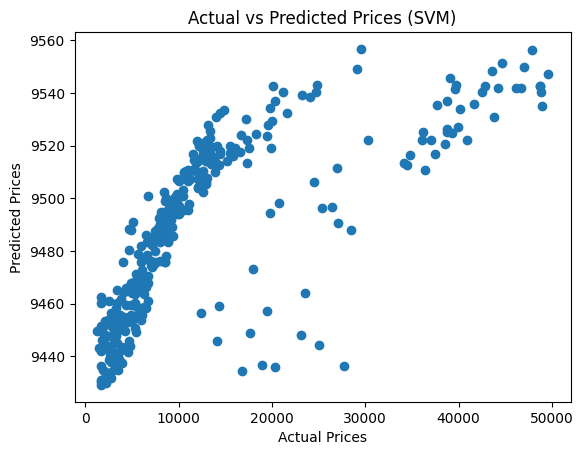

In [17]:
svmr = SVR()
svmr.fit(X_train_scaled, y_train)
y_pred_svmr = svmr.predict(X_test_scaled)
mae_svmr = mean_absolute_error(y_test, y_pred_svmr)
mse_svmr = mean_squared_error(y_test, y_pred_svmr)
r2_svmr = r2_score(y_test, y_pred_svmr)
print(f"SVM MAE: {mae_svmr}")
print(f"SVM MSE: {mse_svmr}")
print(f"SVM R2 Score: {r2_svmr}")
adjusted_r2_svmr = 1 - ( 1-r2_svmr ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_scaled.shape[1] - 1 )
print(f'SVM Adjusted R2: {adjusted_r2_svmr}')
plt.scatter(y_test, y_pred_svmr)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (SVM)")
plt.show()

Our model is not very successful but acceptable for a first try let's hyperparameter tune it and try to improve


In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C' : [0.1, 1, 10,100,1000],
    'gamma' : [0.01, 0.1, 1, 10],
    'kernel' : ['rbf', 'linear']
}

Defined the search space for hyperparameter tuning.

In [19]:
grid = GridSearchCV(SVR(), param_grid,n_jobs=-1 ,verbose=3)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 5/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.101 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.080 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.094 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=0.01, kernel=linear;, score=-0.050 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.056 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=0.01, kernel=linear;, score=-0.088 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.197 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=0.01, kernel=linear;, score=-0.073 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.080 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.056 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.1, kernel=linear;, score=-0.050 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=rbf;

GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [27]:
grid.best_params_

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

Identified the optimal parameters found by GridSearchCV.

In [21]:
grid.best_score_

np.float64(0.6793234933946113)

Checked the best score achieved during cross-validation.

In [22]:
y_pred_grid = grid.predict(X_test_scaled)
mae_grid = mean_absolute_error(y_test, y_pred_grid)
mse_grid = mean_squared_error(y_test, y_pred_grid)
r2_grid = r2_score(y_test, y_pred_grid)
print(f"Grid Search SVM MAE: {mae_grid}")
print(f"Grid Search SVM MSE: {mse_grid}")
print(f"Grid Search SVM R2 Score: {r2_grid}")
adjusted_r2_grid = 1 - ( 1-r2_grid ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_scaled.shape[1] - 1 )
print(f'Grid Search SVM Adjusted R2: {adjusted_r2_grid}')

Grid Search SVM MAE: 2771.622461930139
Grid Search SVM MSE: 37172607.70712808
Grid Search SVM R2 Score: 0.7309804632732285
Grid Search SVM Adjusted R2: 0.7243380055762711


Evaluated the final tuned model and compared it with the baseline.
The score is not enough when compare to linear regression models.

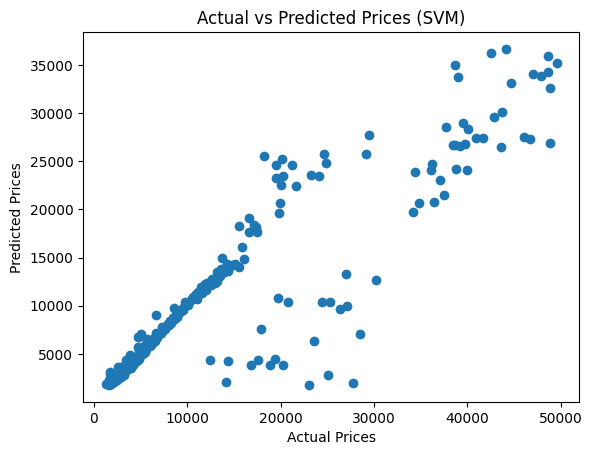

In [23]:
plt.scatter(y_test, y_pred_grid)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (SVM)")
plt.show()

Visualized the predictions of the tuned model against the actual values.

In [28]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid.best_estimator_, X_train, y_train, n_repeats=10, random_state=42)

importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance',ascending=False)

print(importance.sort_values(by='Importance', ascending=False))

AttributeError: coef_ is only available when using a linear kernel